In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize the cart-pole environment with render_mode='human'
env = gym.make('CartPole-v1', render_mode='human')

# Define the state space bins for discretization
num_bins = [6, 12, 6, 12]  # Number of bins for each state variable

# Discretize the state space
def discretize_state(state, bins):
    """Discretizes a continuous state into discrete bins.
    
    Args:
        state (array): The continuous state.
        bins (list): List of the number of bins for each state variable.
        
    Returns:
        tuple: Discretized state as a tuple of bin indices.
    """
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], np.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -np.radians(50)]
    
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    
    new_state = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(bins[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    
    return tuple(new_state)

In [3]:
# Define epsilon-greedy policy
def epsilon_greedy_policy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore action space
    else:
        return np.argmax(Q[state])  # Exploit learned values

In [4]:
# Monte Carlo algorithm
def monte_carlo(env, episodes, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(episodes):
        # Generate an episode
        episode_data = []
        state, _ = env.reset()
        state = discretize_state(state, num_bins)
        done = False
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, num_bins)
            episode_data.append((state, action, reward))
            state = next_state
        
        # Update Q values based on episode
        G = 0
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if not (state, action) in [(x[0], x[1]) for x in episode_data[:-1]]:
                returns_sum[state][action] += G
                returns_count[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / returns_count[state][action]
    
    return Q

In [5]:
# Q-Learning algorithm
def q_learning(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state, num_bins)
        done = False
        
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, num_bins)
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            state = next_state
    
    return Q

In [6]:
# SARSA algorithm
def sarsa(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state, num_bins)
        action = epsilon_greedy_policy(Q, state, epsilon)
        done = False
        
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, num_bins)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon)
            
            td_target = reward + gamma * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            state = next_state
            action = next_action
    
    return Q

In [7]:
def evaluate_policy(env, Q, episodes=100):
    total_rewards = 0
    for _ in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state, num_bins)
        done = False
        while not done:
            action = np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, num_bins)
            state = next_state
            total_rewards += reward
    return total_rewards / episodes

Monte Carlo average reward: 9.4
Q-Learning average reward: 10.3
SARSA average reward: 10.4


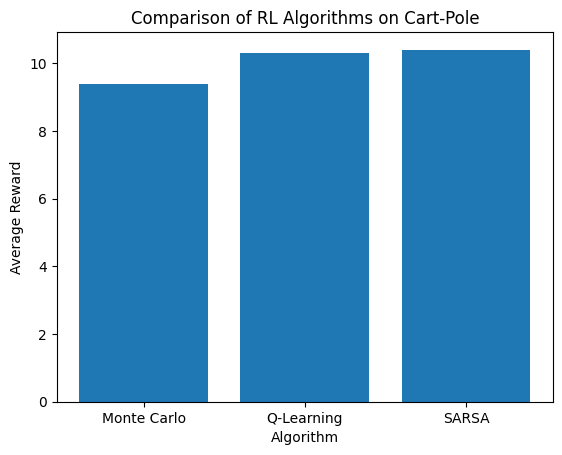

In [9]:
# Training parameters
episodes = 50
eval_episodes = 10

# Train Monte Carlo agent
mc_Q = monte_carlo(env, episodes, gamma=1.0, epsilon=0.1)
mc_reward = evaluate_policy(env, mc_Q, eval_episodes)
print(f"Monte Carlo average reward: {mc_reward}")

# Train Q-Learning agent
ql_Q = q_learning(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1)
ql_reward = evaluate_policy(env, ql_Q, eval_episodes)
print(f"Q-Learning average reward: {ql_reward}")

# Train SARSA agent
sarsa_Q = sarsa(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1)
sarsa_reward = evaluate_policy(env, sarsa_Q, eval_episodes)
print(f"SARSA average reward: {sarsa_reward}")


# Plot comparison of rewards
labels = ['Monte Carlo', 'Q-Learning', 'SARSA']
rewards = [mc_reward, ql_reward, sarsa_reward]

plt.bar(labels, rewards)
plt.xlabel('Algorithm')
plt.ylabel('Average Reward')
plt.title('Comparison of RL Algorithms on Cart-Pole')
plt.show()

env.close()